# *Challenge \#2*: An empirical study on the learnability of functions by *NNs*

## Annalisa Paladino

Advanced Topics in Machine Learning -- Fall 2024, UniTS

In the following *challenge exercises*, we will empirically investigate the behaviour of deep neural networks with respect to the learning of specific classes of functions, and in specific training regimes.

### A. The effect of *under-* and *over-* parameterisation in the *Teacher/Student* setup

In this exercise, we will train deep neural networks (*students*), supervisedly, on input/output pairs produced by another deep neural network with frozen weights (*teacher*).[^1] Given our ability to modulate the expressivity of both networks, this setup allows us to disentangle the effects of task hardness, model expressivity, and training dynamics.

We will monitor the training and test loss of the *students* during training, as well as the final distribution of weights. We will do so in three regimes: when the *student* has much less (*under-parameterisation*), much more (*over-parameterisation*) or exactly the same learnable parameters (within a fixed given structure) as those frozen in the *teacher*.

#### What to do?

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.optim import Adam
import numpy as np
import random
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

SEED = 3407
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


1.   Instantiate the *teacher* model $\mathcal{T}$, a fully-connected feedforward neural network mapping a $100$-dimensional input to a single output scalar. Use  $3$ hidden layers of sizes, respectively: $75$, $50$, $10$. Use the $\mathsf{ReLU}$ activation function after all neurons, except for the output. Weights and biases should be initialised as *i.i.d.* samples from the Standard Normal distribution. Keep those parameters fixed for the rest of the exercise.

In [12]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size=100, hidden_layers=[75, 50, 10], output_size=1):
        super().__init__()
        layers = []
        prev = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, output_size))
        self.model = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=1.0)
                nn.init.normal_(m.bias, mean=0.0, std=1.0)

    def forward(self, x):
        return self.model(x)

2.   Generate the **test set** for the learning task, by repeatedly querying the *teacher* model. Inputs $\boldsymbol{x}_i \in \mathbb{R}^{100}$ should be obtained as samples from the multivariate Uniform distribution in the interval $[0,2]^{100}$, whereas the outputs as $y_i = \mathcal{T}(\boldsymbol{x}_i)$. Generate at least $6 \times 10^4$ datapoints and keep them fixed for the rest of the exercise. Such points will be used as a way to quantify generalisation error by the *student* model.

In [13]:
teacher = FullyConnectedNN().to(DEVICE)
teacher.eval()

N_TEST = int(6e4)
X_test = 2 * torch.rand(N_TEST, 100)
y_test = teacher(X_test.to(DEVICE)).detach().cpu().flatten()

# Put the data into a dataset
test_data = TensorDataset(X_test, y_test)

3.   Instantiate the *student* model $\mathcal{S}$, a fully-connected feedforward neural network mapping a $100$-dimensional input to a single output scalar – as in the case of the teacher. Repeat the steps that follow with (at least) three different *student* models, architecturally identical to the *teacher* but with different number and width of the hidden layers.
     -   $S_u$: one hidden layer of size $10$;
     -   $S_e$: as for the *teacher*;
     -   $S_o$: $4$ hidden layers of sizes $200$, $200$, $200$, $100$;

In [14]:
student_configs = {
    "student_u": [10],
    "student_e": [75, 50, 10],
    "student_o": [200, 200, 200, 100],
}

def get_student(name):
    return FullyConnectedNN(hidden_layers=student_configs[name]).to(DEVICE)

4.   Train the *student* model on the *MSE* loss for a sufficiently large number of iterations, as to allow for the training and test loss to reach a quasi-stationary behaviour. To actually perform the training, harvest a fresh sample of $\mathsf{B}$ inputs (*i.e.* $\left\{{\boldsymbol{x}_1, \dots, \boldsymbol{x}_{\mathsf{B}}}\right\}$) per iteration, label each of them using the *teacher* model, and train the *student* on the given batch. Use an optimizer of your choice, taking care to tune (at least) its learning rate to minimize time to convergence. Do not use default learning rates assuming they are already optimal! Do not optimize batch-size (as it is scarcely effective when tuning also the learning rate[^2]): you can use $\mathsf{B}=128$ (or less, if you cannot make it fit into memory).
     As the training progresses, log the training loss (every batch, if you can). Additionally, log also the test-set loss every given number of batches (of your choice).

In [15]:
def train_student(student, teacher, test_data, lr, epochs=1000, batch_size=128):
    teacher = teacher.to(DEVICE)
    student = student.to(DEVICE)
    loss_fn = nn.MSELoss()
    optimizer = Adam(student.parameters(), lr=lr)

    train_losses, test_losses = [], []

    X_test, y_test = test_data[:]
    X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

    for epoch in trange(epochs, leave=False):
        student.train()
        X_batch = 2 * torch.rand(batch_size, 100).to(DEVICE)
        y_batch = teacher(X_batch).detach().flatten()

        optimizer.zero_grad()
        y_pred = student(X_batch).flatten()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if epoch % 20 == 0:
            student.eval()
            with torch.no_grad():
                val_pred = student(X_test).flatten()
                val_loss = loss_fn(val_pred, y_test).item()
            test_losses.append(val_loss)

    return train_losses, test_losses, student

In [16]:
learning_rates = [5e-4, 5e-3, 1e-2, 3.5e-2, 7e-2, 1e-1, 5e-1] 
best_models = {}

for name in student_configs:
    print(f"\n🔍 Tuning {name}...")
    results = []
    for lr in learning_rates:
        student = get_student(name)
        tr, ev, trained_model = train_student(student, teacher, test_data, lr)
        results.append((lr, ev[-1], tr, ev, trained_model))

    best_lr, best_test, train_loss, tst_loss, model = min(results, key=lambda x: x[1])
    best_models[name] = {
        "model": model,
        "lr": best_lr,
        "train_loss": train_loss,
        "test_loss": tst_loss
    }
    print(f"✔ Best LR for {name}: {best_lr:.1e}, Test Loss: {best_test:.4f}")
'''
learning_rates = [5e-4, 5e-3, 1e-2, 3.5e-2, 7e-2, 1e-1, 5e-1] 
best_models = {}

for name in student_configs:
    print(f"\n🔍 Tuning {name}...")
    results = []
    for lr in learning_rates:
        student = get_student(name)
        tr, ev, trained_model = train_student(student, teacher, test_data, lr)
        results.append((lr, ev[-1], tr[-1], ev, trained_model))  # Assuming tr and ev are lists, we're getting the last elements

    best_lr, best_test, train_loss, tst_loss, model = min(results, key=lambda x: x[1])
    best_models[name] = {
        "model": model,
        "lr": best_lr,
        "train_loss": train_loss,
        "test_loss": tst_loss
    }
    print(f"✔ Best LR for {name}: {best_lr:.1e}, Train Loss: {train_loss:.4f}, Test Loss: {best_test:.4f}")
'''


🔍 Tuning student_u...


✔ Best LR for student_u: 7.0e-02, Test Loss: 11342.1270

🔍 Tuning student_e...


✔ Best LR for student_e: 1.0e-01, Test Loss: 11214.7285

🔍 Tuning student_o...


✔ Best LR for student_o: 3.5e-02, Test Loss: 79931.9453


'\nlearning_rates = [5e-4, 5e-3, 1e-2, 3.5e-2, 7e-2, 1e-1, 5e-1] \nbest_models = {}\n\nfor name in student_configs:\n    print(f"\n🔍 Tuning {name}...")\n    results = []\n    for lr in learning_rates:\n        student = get_student(name)\n        tr, ev, trained_model = train_student(student, teacher, test_data, lr)\n        results.append((lr, ev[-1], tr[-1], ev, trained_model))  # Assuming tr and ev are lists, we\'re getting the last elements\n\n    best_lr, best_test, train_loss, tst_loss, model = min(results, key=lambda x: x[1])\n    best_models[name] = {\n        "model": model,\n        "lr": best_lr,\n        "train_loss": train_loss,\n        "test_loss": tst_loss\n    }\n    print(f"✔ Best LR for {name}: {best_lr:.1e}, Train Loss: {train_loss:.4f}, Test Loss: {best_test:.4f}")\n'

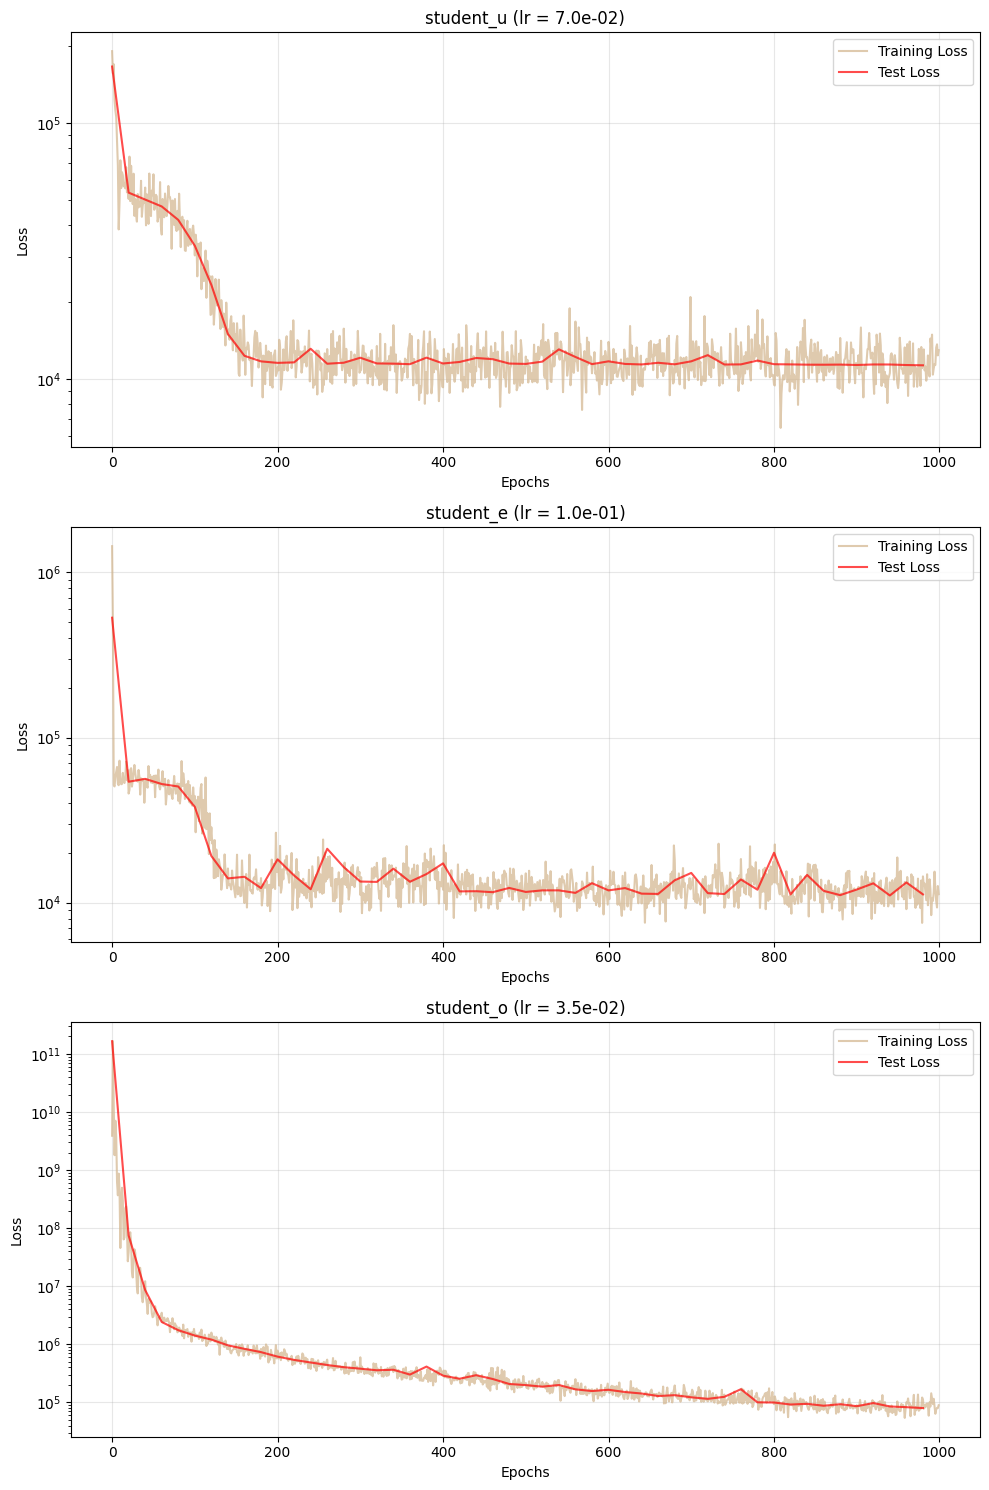

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
names = list(best_models.keys())

for i, name in enumerate(names):
    ax = axes[i]
    tr = best_models[name]["train_loss"]
    ev = best_models[name]["test_loss"]
    lr = best_models[name]["lr"]

    ax.plot(tr, label="Training Loss", color="tan", alpha=0.7) 
    ax.plot(range(0, len(tr), 20), ev, label="Test Loss", color="red", alpha=0.7)
    ax.set_yscale("log")
    ax.set_title(f"{name} (lr = {lr:.1e})")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

5.   Once the training is over, evaluate the *student* model on the test set one last time. Additionally, collect (separately) weights and biases for each layer of the *student* network, and compare their distribution to that of the *teacher* network. Do the same for the collection of all weights and biases of the network (*i.e.* not on a layer-wise basis).

In [18]:
# Final evaluation loss summary
final_losses = [(k, best_models[k]['test_loss'][-1]) for k in best_models]
print(tabulate(final_losses, headers=["Model", "Final Test Loss"]))

Model        Final Test Loss
---------  -----------------
student_u            11342.1
student_e            11214.7
student_o            79931.9


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

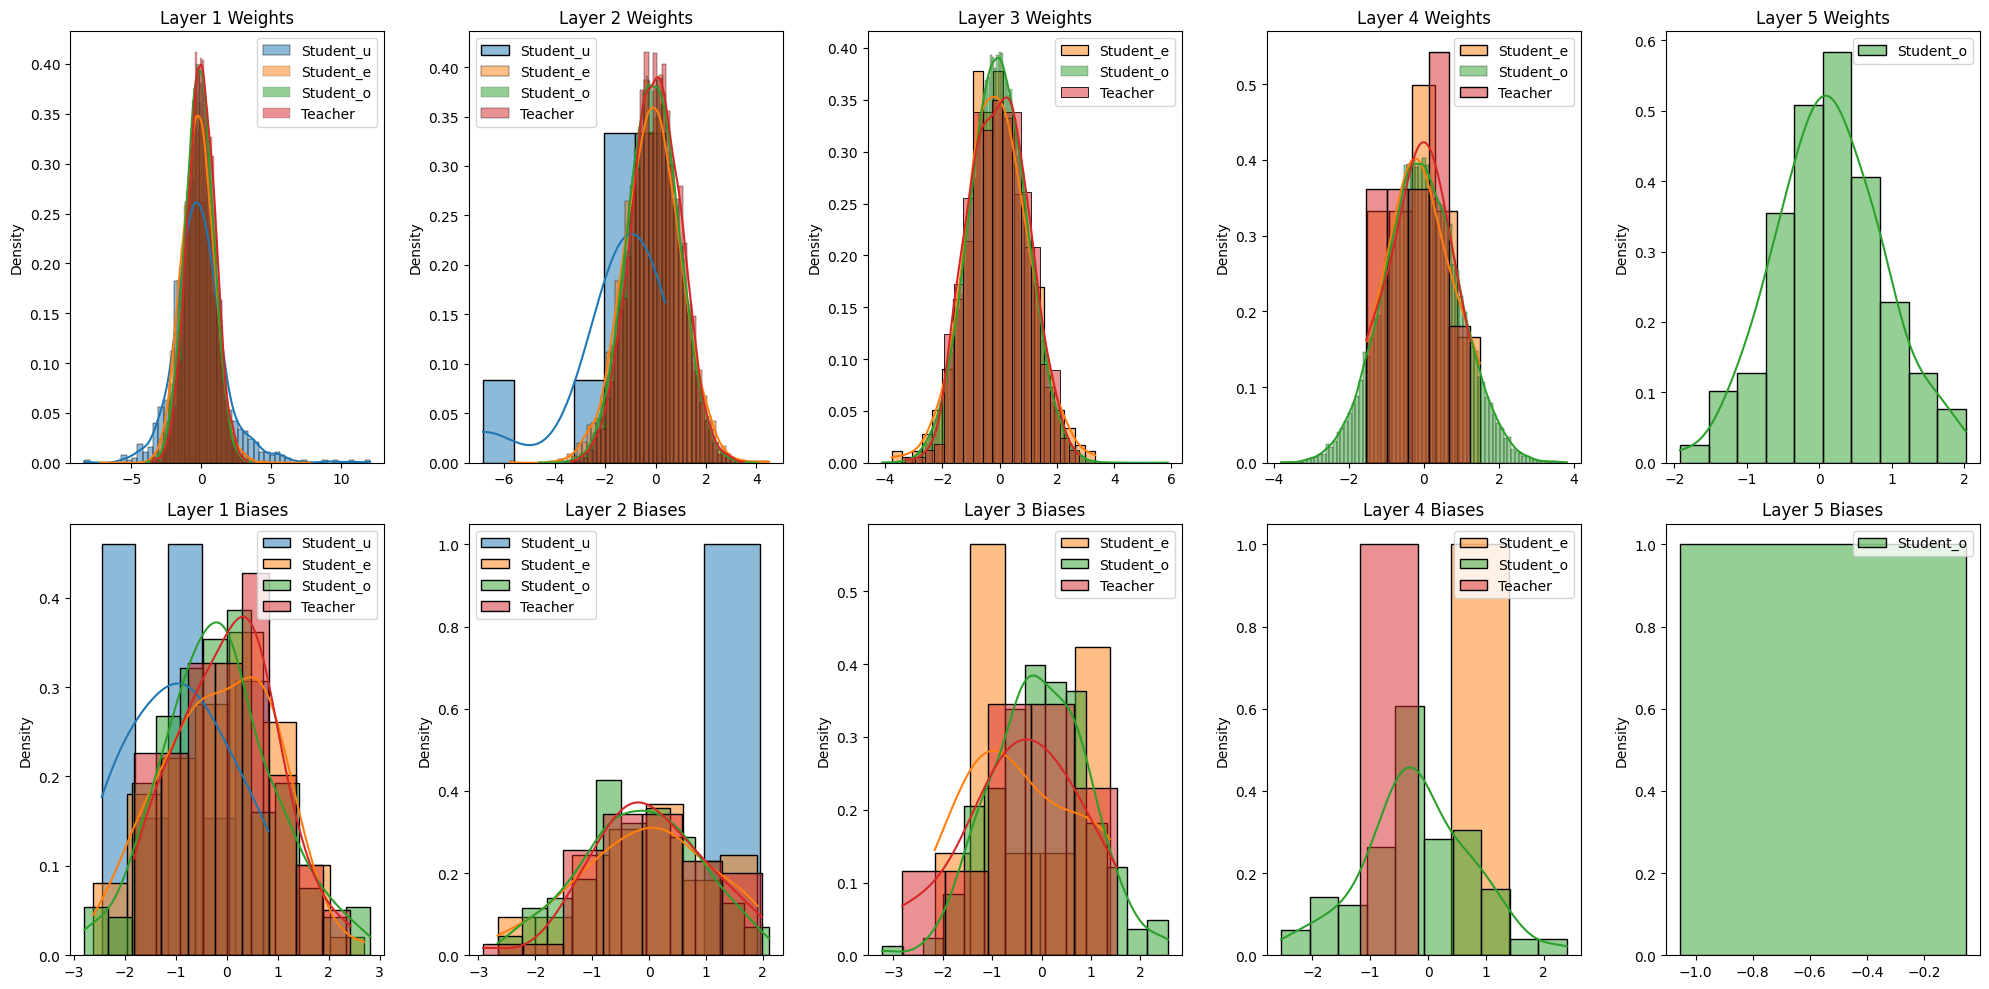

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

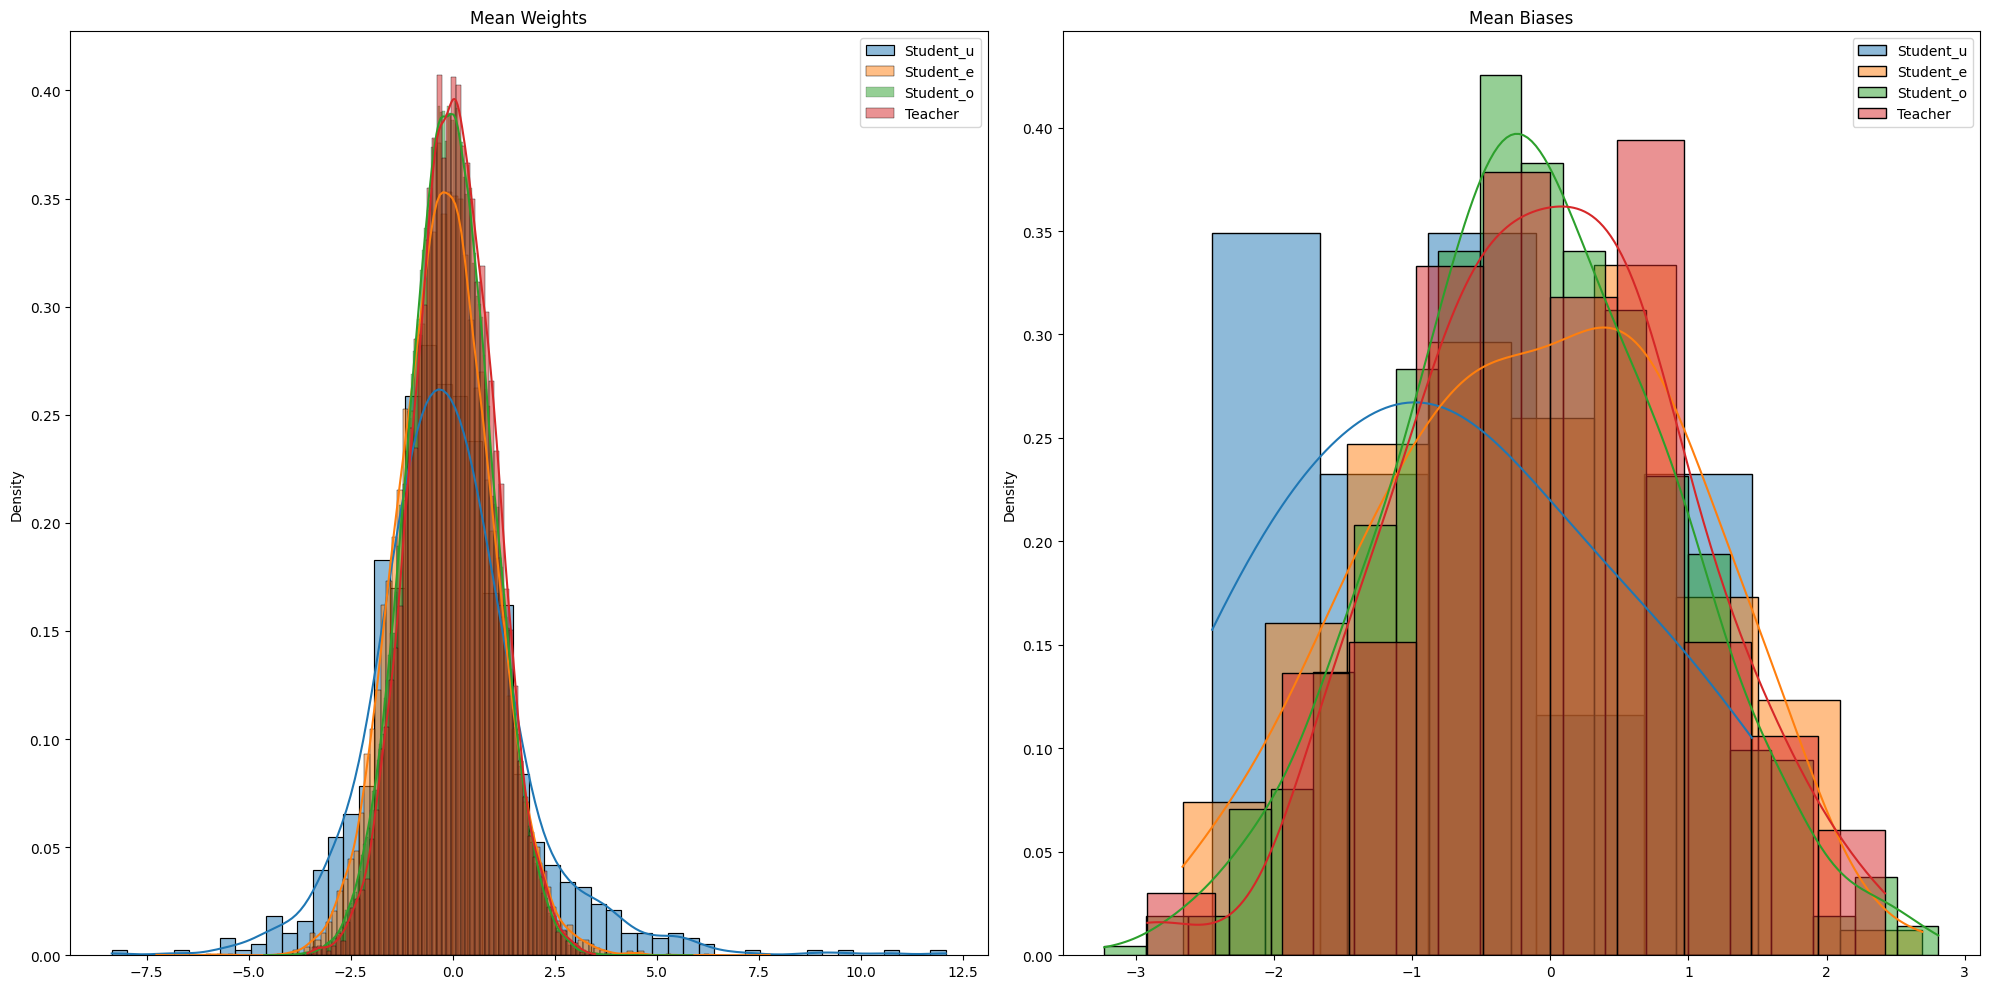

In [19]:
# Extract weights and biases
def extract_params(model):
    weights = []
    biases = []
    for m in model.model:
        if isinstance(m, nn.Linear):
            weights.append(m.weight.data.cpu().numpy().flatten())
            biases.append(m.bias.data.cpu().numpy().flatten())
    return weights, biases

# Initialize containers for weights and biases
student_u_weights, student_u_biases = [], []
student_e_weights, student_e_biases = [], []
student_o_weights, student_o_biases = [], []
teacher_weights, teacher_biases = [], []

# Extract parameters for each model
student_u_weights, student_u_biases = extract_params(best_models['student_u']["model"])
student_e_weights, student_e_biases = extract_params(best_models['student_e']["model"])
student_o_weights, student_o_biases = extract_params(best_models['student_o']["model"])
teacher_weights, teacher_biases = extract_params(teacher)

# Plot histograms of weights and biases for all models
palette = {
    "Student_u": "#1f77b4",  # Blue
    "Student_e": "#ff7f0e",  # Orange
    "Student_o": "#2ca02c",  # Green
    "Teacher": "#d62728",    # Red
}

fig = plt.figure(figsize=(20, 10))

# Determine the maximum number of layers (based on the largest model: student_o with 4 layers)
max_layers = len(student_o_weights)

# Plot Layer-wise Histograms for Weights
for i in range(max_layers):
    ax = fig.add_subplot(2, 5, i + 1)
    
    # For each model, only plot the layers that exist
    if i < len(student_u_weights):
        sns.histplot(student_u_weights[i], kde=True, ax=ax, stat='density', color=palette['Student_u'], label='Student_u')
    if i < len(student_e_weights):
        sns.histplot(student_e_weights[i], kde=True, ax=ax, stat='density', color=palette['Student_e'], label='Student_e')
    if i < len(student_o_weights):
        sns.histplot(student_o_weights[i], kde=True, ax=ax, stat='density', color=palette['Student_o'], label='Student_o')
    if i < len(teacher_weights):
        sns.histplot(teacher_weights[i], kde=True, ax=ax, stat='density', color=palette['Teacher'], label='Teacher')
    
    ax.set_title(f'Layer {i + 1} Weights')
    ax.legend()

# Plot Layer-wise Histograms for Biases
for i in range(max_layers):
    ax = fig.add_subplot(2, 5, i + 6)
    
    # For each model, only plot the layers that exist
    if i < len(student_u_biases):
        sns.histplot(student_u_biases[i], kde=True, ax=ax, stat='density', color=palette['Student_u'], label='Student_u')
    if i < len(student_e_biases):
        sns.histplot(student_e_biases[i], kde=True, ax=ax, stat='density', color=palette['Student_e'], label='Student_e')
    if i < len(student_o_biases):
        sns.histplot(student_o_biases[i], kde=True, ax=ax, stat='density', color=palette['Student_o'], label='Student_o')
    if i < len(teacher_biases):
        sns.histplot(teacher_biases[i], kde=True, ax=ax, stat='density', color=palette['Teacher'], label='Teacher')
    
    ax.set_title(f'Layer {i + 1} Biases')
    ax.legend()

plt.tight_layout()
plt.show()

# Global Histograms for All Weights and Biases
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(121)
sns.histplot(np.concatenate(student_u_weights), kde=True, ax=ax, stat='density', color=palette['Student_u'], label='Student_u')
sns.histplot(np.concatenate(student_e_weights), kde=True, ax=ax, stat='density', color=palette['Student_e'], label='Student_e')
sns.histplot(np.concatenate(student_o_weights), kde=True, ax=ax, stat='density', color=palette['Student_o'], label='Student_o')
sns.histplot(np.concatenate(teacher_weights), kde=True, ax=ax, stat='density', color=palette['Teacher'], label='Teacher')
ax.set_title('Mean Weights')
ax.legend()

ax = fig.add_subplot(122)
sns.histplot(np.concatenate(student_u_biases), kde=True, ax=ax, stat='density', color=palette['Student_u'], label='Student_u')
sns.histplot(np.concatenate(student_e_biases), kde=True, ax=ax, stat='density', color=palette['Student_e'], label='Student_e')
sns.histplot(np.concatenate(student_o_biases), kde=True, ax=ax, stat='density', color=palette['Student_o'], label='Student_o')
sns.histplot(np.concatenate(teacher_biases), kde=True, ax=ax, stat='density', color=palette['Teacher'], label='Teacher')
ax.set_title('Mean Biases')
ax.legend()

plt.tight_layout()
plt.show()

In [20]:
# Function to count the number of weights and biases for each model
def count_weights_and_biases(model):
    weight_count = 0
    bias_count = 0
    for m in model.model:
        if isinstance(m, nn.Linear):
            weight_count += m.weight.numel()  # .numel() returns the total number of elements in the tensor
            bias_count += m.bias.numel()
    return weight_count, bias_count

# Display the number of weights and biases for each model
print("Number of Weights and Biases for Each Model:\n")
models = {
    "Teacher": teacher,
    "Student_u": best_models['student_u']["model"],
    "Student_e": best_models['student_e']["model"],
    "Student_o": best_models['student_o']["model"]
}

for model_name, model in models.items():
    weight_count, bias_count = count_weights_and_biases(model)
    print(f"{model_name}:")
    print(f"  Number of Weights: {weight_count}")
    print(f"  Number of Biases: {bias_count}")
    print()

Number of Weights and Biases for Each Model:

Teacher:
  Number of Weights: 11760
  Number of Biases: 136

Student_u:
  Number of Weights: 1010
  Number of Biases: 11

Student_e:
  Number of Weights: 11760
  Number of Biases: 136

Student_o:
  Number of Weights: 120100
  Number of Biases: 701



Comment on the results collected, specifically in terms of: number of learnable parameters, trainability, generalisation, distributional convergence to target parameters. Do so individually in each case, as well as in comparison across the different *student* models.

### B. Function learning and hierarchical structure

In this exercise, we will train a particular kind of *deep residual network*, supervisedly, on examples generated by two specific polynomials. Although their monomials share most of their respective properties, one polynomial shows a strongly hierarchical structure[^3], whereas the other does not. The hierarchical polynomial is $B_6$, *i.e.* the *sixth-order multivariate complete Bell polynomial*, which is defined as follows.
$$
B_6(x_1, x_2, x_3, x_4, x_5, x_6) = x_1^6 + 15x_2x_1^4 + 20x_3x_1^3 + 45x_2^2x_1^2 + 15x_2^3 + 60x_3x_2x_1 + 15x_4x_1^2 + 10x_3^2 + 15x_4x_2 + 6x_5x_1 + x_6 \text{.}
$$
We will analyse the generalisation error of the same model trained to reproduce each of the two polynomials, both in terms of general input/output mapping ability and sensitivity with respect to the variation of individual input components.

#### What to do?

In [17]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from torch.optim import Adam
import numpy as np
import copy
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(3407) # 1234
np.random.seed(3407)

DEVICE = 'cpu'

1.   Define the non-hierarchical counterpart of $B_6$, which we will call $\tilde{B}_6: \mathbb{R}^6 \rightarrow \mathbb{R}$, with a *scrambled* monomial structure. In detail, start from the definition of $B_6$ and iteratively replace the $x_{i_k}$ from each $i^{\text{th}}$ monomial with a different $x_{i_{\sigma_{i}(k)}}$ so that:

     -   $\tilde{B}_6$ still depends non-trivially on all six input variables $x_1, x_2, x_3, x_4, x_5, x_6$.
     -   No two monomials of $\tilde{B}_6$ share the same permutation $\sigma_{i}$ of indices.
     -   No two monomials (regardless of their coefficient), although not sharing the same permutation $\sigma_{i}$ of indices, can be rearranged as such by means of the commutative property of sums and/or products. This should be a concern only for the two terms $15x_4x_2$ and $6x_5x_1$.

In [18]:
def B6(X):
    return (
        X[:, 0]**6 +                             # x1^6
        15 * X[:, 1] * X[:, 0]**4 +              # 15 * x2 * x1^4
        20 * X[:, 2] * X[:, 0]**3 +              # 20 * x3 * x1^3
        45 * X[:, 1]**2 * X[:, 0]**2 +           # 45 * x2^2 * x1^2
        15 * X[:, 1]**3 +                        # 15 * x2^3
        60 * X[:, 2] * X[:, 1] * X[:, 0] +       # 60 * x3 * x2 * x1
        15 * X[:, 3] * X[:, 0]**2 +              # 15 * x4 * x1^2
        10 * X[:, 2]**2 +                        # 10 * x3^2
        15 * X[:, 3] * X[:, 1] +                 # 15 * x4 * x2
        6  * X[:, 4] * X[:, 0] +                 # 6  * x5 * x1
        X[:, 5]                                  # x6
    )


def B6_tilde(X):
    return (
        X[:, 1]**6 +                            # x2^6
        15 * X[:, 2] * X[:, 1]**4 +             # 15 * x3 * x2^4
        20 * X[:, 0] * X[:, 3]**3 +             # 20 * x1 * x4^3
        45 * X[:, 4]**2 * X[:, 2]**2 +          # 45 * x5^2 * x3^2
        15 * X[:, 5]**3 +                       # 15 * x6^3
        60 * X[:, 3] * X[:, 5] * X[:, 4] +      # 60 * x4 * x6 * x5
        15 * X[:, 0] * X[:, 4]**2 +             # 15 * x1 * x5^2
        10 * X[:, 1]**2 +                       # 10 * x2^2
        15 * X[:, 2] * X[:, 5] +                # 15 * x3 * x6
        6  * X[:, 3] * X[:, 0] +                # 6  * x4 * x1
        X[:, 4]                                 # x5
    )

2.   Generate both a **training set** and a **test set** associated with $B_6$ and $\tilde{B}_6$. In particular:

     -   Harvest *i.i.d.* input vectors $\boldsymbol{x} = (x_1,\dots,x_{6}) \in \mathbb{R}^{6}$ from the multivariate Uniform distribution in the interval $[0,2]^{6}$;
     -   Compute the associated output scalar $y \in \mathbb{R}$ as $y = B_6(\boldsymbol{x})$ or $y = \tilde{B}_6(\boldsymbol{x})$. You do not need to share the same inputs $\boldsymbol{x}$ among the datasets generated by the two polynomials.

     Each training set should contain at least $10^{5}$ datapoints, whereas each test set at least $6\times 10^{4}$.

In [19]:
X_train = 2 * torch.rand(int(1e5), 6)
X_test = 2 * torch.rand(int(6e4), 6)

y_train = B6(X_train)
y_test = B6(X_test)

train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

X_train_tilde = 2 * torch.rand(int(1e5), 6)
X_test_tilde = 2 * torch.rand(int(6e4), 6)

y_train_tilde = B6_tilde(X_train_tilde)
y_test_tilde = B6_tilde(X_test_tilde)

train_set_tilde = TensorDataset(X_train_tilde, y_train_tilde)
test_set_tilde = TensorDataset(X_test_tilde, y_test_tilde)

3.   Instantiate the model as a *fully-connected residual* deep neural network, *i.e.* a fully-connected feedforward neural network where each layer is endowed with a ResNet-style skip connection. Layers of different sizes share no skip connection, which is simply dropped.

     Use a network with $9$ layers ($1$ input layer, $8$ hidden layers, $1$ output layer), where hidden layers have all size $50$. Use the $\mathsf{ReLU}$ activation function after all neurons, except for the output.

In [20]:
class ResBlock(nn.Module):
	def __init__(self, input_dim, output_dim):
		super(ResBlock, self).__init__()
		self.layer = nn.Sequential(
			nn.Linear(input_dim, output_dim),
			nn.ReLU(),
		)
		
	def forward(self, x):
		return x + self.layer(x)
      
class ResNet(nn.Module):
	def __init__(self, input_dim, output_dim, hidden_layers=8, hidden_size=50):
		super(ResNet, self).__init__()
		self.model = nn.Sequential(
			nn.Linear(input_dim, hidden_size),
			nn.ReLU(),
		)

		for i in range(hidden_layers):
			self.model.add_module(f'resblock_{i}', ResBlock(hidden_size, hidden_size))

		self.model.add_module('output', nn.Linear(hidden_size, output_dim))

	def forward(self, x):
		return self.model(x)

4.   Train the model (in each of the two cases, *i.e.* $B_6$ and $\tilde{B}_6$) on the *MSE* loss for at least $30$ epochs, using a batch size $\mathsf{B}=20$. Use the $\mathsf{Adam}$ optimiser, with a learning rate tuned to minimise training error (independently across the two datasets). As the training progresses, log the training and test losses (at least once at the end of each epoch).

In [21]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

train_loader_tilde = DataLoader(train_set_tilde, batch_size=256, shuffle=True)
test_loader_tilde = DataLoader(test_set_tilde, batch_size=256, shuffle=False)

In [22]:
def train_model(
    model,
    train_loader,
    test_loader,
    optimizer_cls=optim.Adam,
    learning_rate=1e-3,
    num_epochs=30,
    log_interval=1,
    verbose=True,
    device=DEVICE
):
    model = model.to(device)
    if verbose:
        print(f"Training on device: {device}")

    optimizer = optimizer_cls(
        model.parameters(),
        lr=learning_rate,
        weight_decay=1e-5,
        betas=(0.9, 0.999)
    )
    loss_fn = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in tqdm(range(num_epochs), desc="Training", disable=not verbose):
        model.train()
        cumulative_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            cumulative_loss += loss.item()

        epoch_train_loss = cumulative_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                predictions = model(inputs).squeeze()
                test_loss += loss_fn(predictions, targets).item()

        epoch_test_loss = test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)

        if verbose and (epoch + 1) % log_interval == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} - "
                  f"Train Loss: {epoch_train_loss:.6f} - "
                  f"Test Loss: {epoch_test_loss:.6f}")

    return train_losses, test_losses

In [23]:
def search_learning_rate(
    model_fn,
    learning_rates,
    train_loader,
    test_loader,
    num_epochs=30,
    log_interval=1,
    verbose=False,
    device=DEVICE
):
    best_lr = None
    best_loss = float('inf')
    best_state = None
    best_train_history = None
    best_test_history = None

    for lr in learning_rates:
        print(f"\nEvaluating learning rate: {lr}")
        model = model_fn()

        train_loss, test_loss = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            learning_rate=lr,
            num_epochs=num_epochs,
            log_interval=log_interval,
            verbose=verbose,
            device=device
        )

        final_test_loss = test_loss[-1]
        print(f"Final Test Loss = {final_test_loss:.6f}")

        if final_test_loss < best_loss:
            best_loss = final_test_loss
            best_lr = lr
            best_state = copy.deepcopy(model.state_dict())
            best_train_history = train_loss
            best_test_history = test_loss

    best_model = model_fn()
    best_model.load_state_dict(best_state)
    print(f"\n Best learning rate: {best_lr:.1e} with test loss: {best_loss:.6f}")
    return best_lr, best_model, best_loss, best_train_history, best_test_history

In [24]:
# Search best learning rates
model_constructor = lambda: ResNet(6, 1)
candidate_lrs = [5e-5, 1e-4, 3e-4] # 1e-4, 3e-4, 5e-3, 1e-3, 1e-2, 5e-1

best_lr, best_model, best_loss, train_hist, test_hist = search_learning_rate(
    model_fn=model_constructor,
    learning_rates=candidate_lrs,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=30,
    log_interval=1,
    verbose=False
)

print("Best learning rate (B6):", best_lr)
# print("Best final train loss (B6):", train_hist[-1])
print("Best final test loss (B6):", best_loss)

tilde_best_lr, _, tilde_best_loss, _, _ = search_learning_rate(
    model_constructor,
    candidate_lrs,
    train_loader_tilde,
    test_loader_tilde,
    num_epochs=30,
    log_interval=1,
    verbose=False
)

print("Best learning rate (B6_tilde):", tilde_best_lr)
# print("Best final train loss (B6_tilde):", tilde_train_hist[-1])
print("Best final test loss (B6_tilde):", tilde_best_loss)


Evaluating learning rate: 5e-05
Final Test Loss = 28.263845

Evaluating learning rate: 0.0001
Final Test Loss = 19.135970

Evaluating learning rate: 0.0003
Final Test Loss = 7.863075

 Best learning rate: 3.0e-04 with test loss: 7.863075
Best learning rate (B6): 0.0003
Best final test loss (B6): 7.863075317220485

Evaluating learning rate: 5e-05
Final Test Loss = 126.246743

Evaluating learning rate: 0.0001
Final Test Loss = 55.658582

Evaluating learning rate: 0.0003
Final Test Loss = 37.624398

 Best learning rate: 3.0e-04 with test loss: 37.624398
Best learning rate (B6_tilde): 0.0003
Best final test loss (B6_tilde): 37.62439840600846


In [25]:
# Train models using best LRs found
model = ResNet(6, 1)
train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    learning_rate=best_lr,
    num_epochs=50,
    log_interval=1,
    verbose=False,
    device=DEVICE
)
torch.save(model.state_dict(), "model.pth")

tilde_model = ResNet(6, 1)
tilde_train_losses, tilde_test_losses = train_model(
    tilde_model,
    train_loader_tilde,
    test_loader_tilde,
    learning_rate=tilde_best_lr,
    num_epochs=50,
    log_interval=1,
    verbose=False,
    device=DEVICE
)
torch.save(tilde_model.state_dict(), "tilde_model.pth")

5.   Once the training is over, evaluate the model one last time on the test set. The result of such evaluation will be used as the *final* generalisation error.

In [26]:
# Final test evaluation
def final_test_evaluation(model, X_test, y_test, device=DEVICE):
    model.to(device)
    model.eval()

    criterion = nn.MSELoss()

    with torch.no_grad():
        X_test_dev = X_test.to(device)
        y_test_dev = y_test.to(device)
        y_pred = model(X_test_dev).squeeze()
        test_loss = criterion(y_pred, y_test_dev).item()

    return test_loss

final_test_loss = final_test_evaluation(model, X_test, y_test)
print(f"Final generalisation error hierarchical model: {final_test_loss:.3f}")

tilde_final_test_loss = final_test_evaluation(tilde_model, X_test_tilde, y_test_tilde)
print(f"Final generalisation error scrambled model: {tilde_final_test_loss:.3f}")

Final generalisation error hierarchical model: 3.467
Final generalisation error scrambled model: 19.856


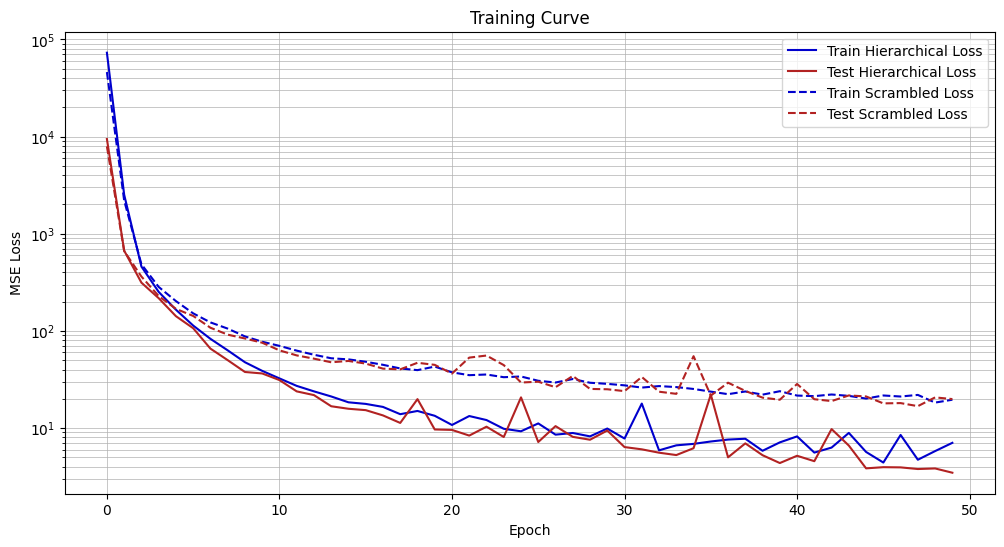

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Hierarchical Loss", color='mediumblue') # midnight
plt.plot(test_losses, label="Test Hierarchical Loss", color='firebrick') # yellowgreen
plt.plot(tilde_train_losses, label="Train Scrambled Loss", color='mediumblue', linestyle='--')
plt.plot(tilde_test_losses, label="Test Scrambled Loss", color='firebrick', linestyle='--')
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, which="both", ls="-", lw=0.5)
plt.legend()
plt.title("Training Curve")
plt.savefig("training_curve.png")
plt.show()

6.   Investigate how the trained network models the dependency of the output on each input variable separately. To do so, proceed as follows.

     -   Harvest a new input vector $\boldsymbol{x} = (x_1,\dots,x_{6}) \in \mathbb{R}^{6}$ from the multivariate Uniform distribution in the interval $[0,2]^{6}$;
     -   For each of the input components, keep all the others fixed to their sampled value, whereas the one considered is evaluated on a fine uniform 1D grid $\mathcal{G} \subset [0,2]$.
     -   Evaluate both the target polynomial and the trained model on all resulting input points so generated, grouping their results according to the variable that is swept along the input interval. Compare the results of the sweeps (it is better to do so graphically!).

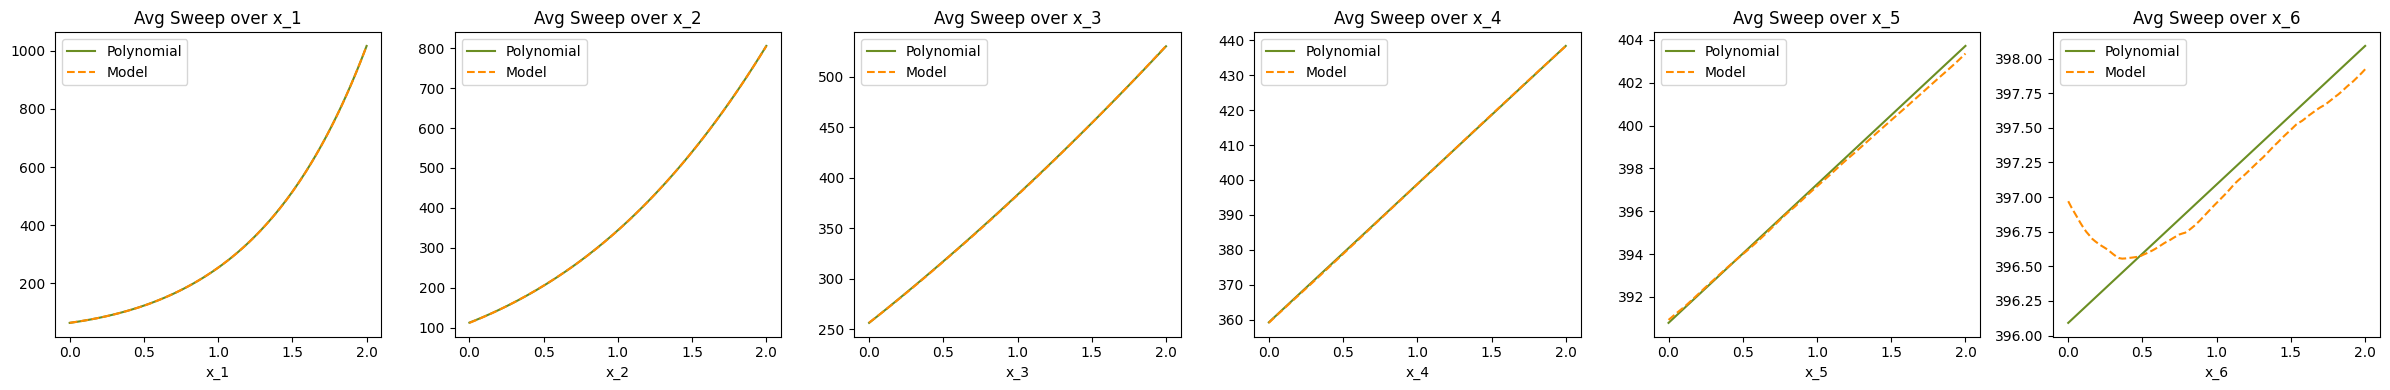

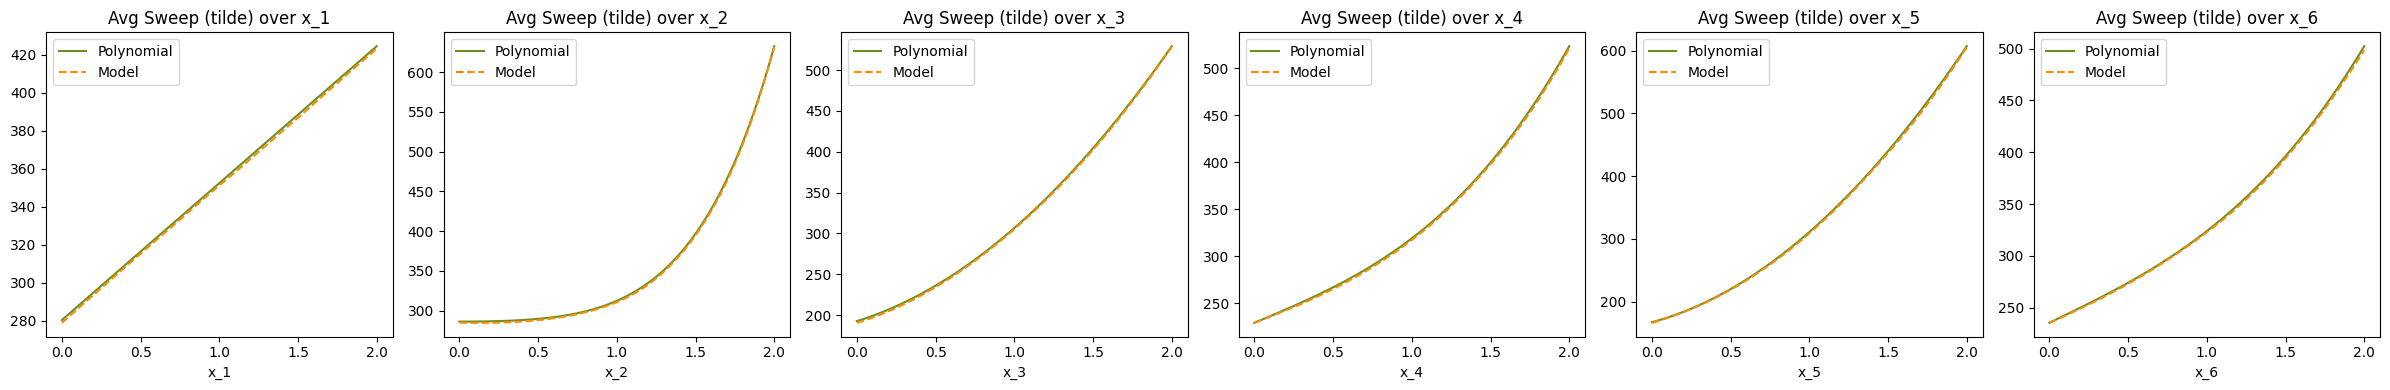

In [28]:
class InputSweeper:
    def __init__(self, model, polynomial_fn, device=DEVICE, n_points=100): # 'cpu'
        self.model = model.to(device).eval()
        self.polynomial_fn = polynomial_fn
        self.device = device
        self.n_points = n_points
        self.input_dim = 6
        self.grid = torch.linspace(0, 2, n_points)

    def _create_sweep_tensor(self, base_vector, dim_index):
        sweep_tensor = base_vector.repeat(self.n_points, 1)
        sweep_tensor[:, dim_index] = self.grid
        return sweep_tensor

    def _evaluate(self, X):
        with torch.no_grad():
            y_poly = self.polynomial_fn(X)
            y_model = self.model(X.to(self.device)).squeeze().cpu()
        return y_poly.numpy(), y_model.numpy()

    def sweep_once(self, x=None):
        x = x if x is not None else 2 * torch.rand(self.input_dim)
        results = []

        for i in range(self.input_dim):
            X_sweep = self._create_sweep_tensor(x, i)
            y_poly, y_model = self._evaluate(X_sweep)
            results.append({
                'dim': i,
                'x_fixed': x.clone(),
                'x_sweep': self.grid.numpy(),
                'y_poly': y_poly,
                'y_model': y_model
            })
        return results

    def sweep_average(self, n_sweeps=5):
        accum_poly = [np.zeros(self.n_points) for _ in range(self.input_dim)]
        accum_model = [np.zeros(self.n_points) for _ in range(self.input_dim)]

        for _ in range(n_sweeps):
            sweep_data = self.sweep_once()
            for i, result in enumerate(sweep_data):
                accum_poly[i] += result['y_poly']
                accum_model[i] += result['y_model']

        avg_poly = [arr / n_sweeps for arr in accum_poly]
        avg_model = [arr / n_sweeps for arr in accum_model]
        return avg_poly, avg_model

    def plot_results(self, poly_data, model_data, title_prefix="Sweep", save_path=None):
        fig, axes = plt.subplots(1, self.input_dim, figsize=(24, 4))
        for i in range(self.input_dim):
            axes[i].plot(self.grid.numpy(), poly_data[i], label='Polynomial', color='olivedrab')
            axes[i].plot(self.grid.numpy(), model_data[i], label='Model', color='darkorange', linestyle='--')
            axes[i].set_xlabel(f"x_{i+1}")
            axes[i].set_title(f"{title_prefix} over x_{i+1}")
            axes[i].legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

test_vector = 2 * torch.rand(6)

sweeper = InputSweeper(model, polynomial_fn=B6, device=DEVICE, n_points=100)
avg_poly, avg_model = sweeper.sweep_average(n_sweeps=100)
sweeper.plot_results(avg_poly, avg_model, title_prefix="Avg Sweep")

sweeper_scr = InputSweeper(tilde_model, polynomial_fn=B6_tilde, device=DEVICE, n_points=100)
avg_poly_scr, avg_model_scr = sweeper_scr.sweep_average(n_sweeps=100)
sweeper_scr.plot_results(avg_poly_scr, avg_model_scr, title_prefix="Avg Sweep (tilde)")

Comment on the results. How does the hierarchical structure of the function to be learnt influence the learning process and/or the *final* learnt model?

[^1]: E. Gardner and B. Derrida; Three unfinished works on the optimal storage capacity of networks. Journal of Physics A: Mathematical and General, 22(12):1983–1994, 1989.

[^2]: V. Godbole, G.E. Dahl, J. Gilmer, C.J. Shallue and Z. Nado; Deep Learning Tuning Playbook, 2023.

[^3]: T. Poggio and M. Fraser; Compositional sparsity of learnable functions. Bulletin of the American Mathematical Society, 61:438-456, 2024.